In [ ]:
import pandas as pd
import numpy as np
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
import seaborn as sns
from sklearn.metrics import fbeta_score
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()
import entropy
from entropy import *

In [ ]:
from typing import Tuple, Callable, List, Dict
from functools import partial

In [ ]:
def make_partials(fns_and_args: List[Tuple[str, Callable, Dict]]) -> List[Callable]:
    return [partial(fn, **args) for _, fn, args in fns_and_args]

In [ ]:
#Look into maybe doing this with scikit transformers?
def summarize_ts(X: np.ndarray, fns_and_args: List[Tuple[str, Callable, Dict]]) -> pd.Series:
    partials = make_partials(fns_and_args)
    return pd.DataFrame(dict(zip((tup[0] for tup in fns_and_args),
                                (np.apply_along_axis(partial,
                                                    1,
                                                    X) for partial in partials))))


In [ ]:
partials = make_partials([("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,})])

test = summarize_ts(X, [("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,})])

In [ ]:
sf =  173.61
#Try everything again with filtering?

In [ ]:
np.apply_along_axis(partials[0],
                   1,
                   X).shape

In [3]:
df = pd.read_csv("../../data/interim/train.csv")


In [4]:
X = df.drop(columns = ["y", "Participant"])

y = df["y"]

In [ ]:
test = summarize_ts(X, [("perm_entropy", perm_entropy, {"order": 3, "normalize": True}),
                         ("svd_entropy", svd_entropy, {"order": 3,
                                       "delay": 1,
                                       "normalize": True,}),
                       ("petrosian_fd", petrosian_fd, {}),
                       ("app_entropy", app_entropy,  {"order": 2, "metric": "chebyshev"}),
                       ("sample_entropy", sample_entropy, {"order": 2, "metric": "chebyshev"}),
                       ("spectral_entropy", spectral_entropy, {"sf": 173.61, "method": "welch", "normalize": True}),
                       ("katz_fd", katz_fd, {}),
                       ("higuchi_fd", higuchi_fd, {"kmax": 10}),
                       ("detrended_fluctuation", detrended_fluctuation, {}),
                       ])

In [37]:
from typing import Tuple

def run_xgboost_experiment(X: pd.DataFrame, y: pd.Series) -> Tuple[
    xgboost.XGBClassifier, 
      float, 
      np.ndarray,
    pd.DataFrame]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    D_train = xgboost.DMatrix(X_train, label=y_train)
    D_test = xgboost.DMatrix(X_test, label=y_test)
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    score = fbeta_score(y_test, preds, beta=2)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    return model, score, shap_values, X_train

def make_shap_df(shap_vals: np.ndarray, X: pd.DataFrame) -> pd.DataFrame:
    mean_shap_vals = np.abs(shap_vals).mean(0)
    
    return (pd.DataFrame({"feature": X.columns,
                       "SHAP": mean_shap_vals})
            .query("SHAP > 0")
            .assign(rank = lambda x: x["SHAP"].rank(ascending=False))
            .sort_values(by="SHAP", ascending=False))

In [38]:
model, score, shap_values, X_train = run_xgboost_experiment(test, y)

Series.base is deprecated and will be removed in a future version
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [39]:
score

0.9150757077024356

In [41]:
shap_df = make_shap_df(shap_values, test)
shap_df

,feature,SHAP,rank
0,perm_entropy,1.720369,1.0
4,sample_entropy,1.646216,2.0
1,svd_entropy,1.007910,3.0
3,app_entropy,0.459928,4.0
7,higuchi_fd,0.227037,5.0
5,spectral_entropy,0.203220,6.0
6,katz_fd,0.200584,7.0
2,petrosian_fd,0.163790,8.0
8,detrended_fluctuation,0.018463,9.0


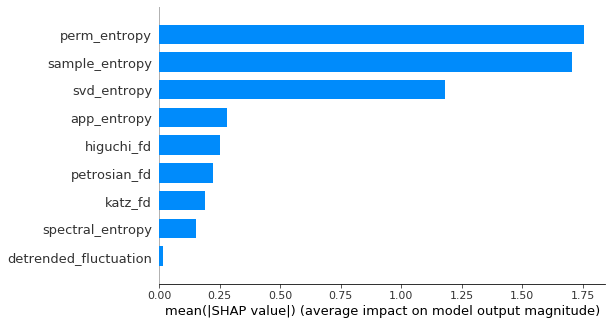

In [61]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

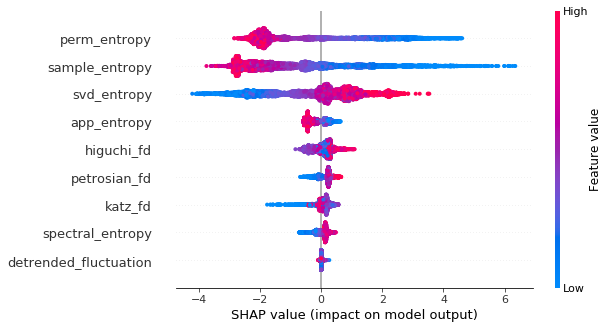

In [62]:
shap.summary_plot(shap_values, X_train)